In [13]:
!pip install natasha
!pip install fasttext numpy

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 97.4 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=d1e2c9875b96491d76134aa2f7a3c2ef706529198c388915ebf15602e1b78025
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26098 sha256=b9625b1d81d2f716ddadc0c9dad278384cf8dfe5de2af8f7f0061647100735c7
  Stored in directory: /root/.cache/pip/wheels/31/d7/d9/eec6891f78cac19a693bd40ecb8365d2f4613318c145ec9816
Successfully built docopt intervaltree
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [14]:
from natasha import (
    Segmenter, MorphVocab,
    NewsNERTagger,
    NewsEmbedding,
    NewsMorphTagger,
    Doc
)
import re

import fasttext
import os
import numpy as np
from google.colab import files
from scipy.spatial import distance

from tqdm import tqdm

In [16]:
#Предобработка текстов

class TextProcessor:
    def __init__(self):
        # Инициализация компонентов Natasha
        self.segmenter = Segmenter()
        self.emb = NewsEmbedding()
        self.morph_tagger = NewsMorphTagger(self.emb)
        self.ner_tagger = NewsNERTagger(self.emb)
        self.morph_vocab = MorphVocab()

        # Словарь для замены сущностей
        self.label_dict = {'NUM': '0', 'PRON': '1', 'PER': '2', 'LOC': '3', 'ORG': '4'}
        self.next_label_num = 5

    def _replace_numbers(self, text):
        return re.sub(r'\d+', '0', text)

    def _process_ner(self, text):
        doc = Doc(text)
        doc.segment(self.segmenter)
        doc.tag_ner(self.ner_tagger)

        # Обработка сущностей в обратном порядке
        for span in reversed(doc.ner.spans):
            if span.type not in self.label_dict:
                self.label_dict[span.type] = str(self.next_label_num)
                self.next_label_num += 1
            text = text[:span.start] + self.label_dict[span.type] + text[span.stop:]
        return text

    def _lemmatize_text(self, text):
        doc = Doc(text)
        doc.segment(self.segmenter)
        doc.tag_morph(self.morph_tagger)

        prepared_text = []
        prev_num = False

        for token in doc.tokens:
            if token.pos == 'NUM' and not token.text.isdigit():
                if not prev_num:
                    prepared_text.append('0')
                    prev_num = True
                continue

            prev_num = False

            if token.pos in self.label_dict:
                prepared_text.append(self.label_dict[token.pos])
            elif token.pos != 'PUNCT':
                try:
                    token.lemmatize(self.morph_vocab)
                    prepared_text.append(token.lemma.lower())
                except Exception:
                    prepared_text.append(token.text.lower())

        return ' '.join(prepared_text)

    def process_joke(self, joke):
        text = self._replace_numbers(joke)
        text = self._process_ner(text)
        return self._lemmatize_text(text)

def main():
    processor = TextProcessor()

    # Загрузка файла
    uploaded = files.upload()
    if not uploaded:
        print("Файл не загружен!")
        return

    input_filename = next(iter(uploaded))

    # Чтение файла
    with open(input_filename, 'r', encoding='utf-8') as f:
        content = f.read()

    # Разделение на тексты
    jokes = [joke.strip() for joke in content.split('/') if joke.strip()]
    total_jokes = len(jokes)

    # Обработка с прогресс-баром
    cleaned_jokes = []
    for joke in tqdm(jokes, desc="Обработка текстов", unit="шт"):
        cleaned_jokes.append(processor.process_joke(joke))

    # Сохранение результата
    output_filename = 'cleaned_' + input_filename
    with open(output_filename, 'w', encoding='utf-8') as f:
        f.write(' / '.join(cleaned_jokes))

    # Скачивание
    print(f"\n Обработано текстов: {total_jokes}")
    files.download(output_filename)

if __name__ == "__main__":
    main()

Файл не загружен!


In [ ]:
#Превращение обработанных текстов в эмбеддинги

# Скачивание модели
model_url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ru.zip'
model_name = 'wiki.ru.bin'

if not os.path.exists(model_name):
    !wget {model_url}
    !unzip wiki.ru.zip

# Загрузка модели
model = fasttext.load_model(model_name)

def process_text(input_file, output_npz):
    # Чтение файла
    with open(input_file, 'r', encoding='utf-8') as f:
        content = f.read().strip()

    # Разделение на тексты
    texts = content.split(' / ')

    # Сбор данных
    data = {}
    for i, text in enumerate(texts):
        words = text.split()
        vectors = np.array([model.get_word_vector(word) for word in words])
        data[f'text_{i}'] = vectors

    # Сохранение в NPZ
    np.savez(output_npz, **data)
    print(f"Сохранено {len(texts)} текстов")

# Загрузка файла
uploaded = files.upload()
input_filename = next(iter(uploaded))
output_filename = 'text_vectors.npz'

process_text(input_filename, output_filename)

# Скачивание
files.download(output_filename)

Saving cleaned_texts.txt to cleaned_texts (1).txt
Сохранено 34 текстов


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
#Вывод ВСЕХ массивов векторов (в самом массиве показывает только первые пять векторов)

# Загрузка NPZ-файла
uploaded = files.upload()
filename = next(iter(uploaded))

# Загрузка данных из NPZ-файла
data = np.load(filename)

# Просмотр содержимого файла
print("Содержимое файла:")
print("=" * 50)
print(f"Файл содержит {len(data.files)} текстов")
print("Список ключей:", data.files)

# Просмотр примеров векторов
for i, key in enumerate(data.files):  # Проходим по всем текстам
    vectors = data[key]
    print(f"\nТекст {i + 1} ({key}):")
    print(f"Количество слов: {len(vectors)}")
    print("Примеры векторов:")
    print(vectors[:5])  # Показываем первые 5 векторов
    print("Размерность векторов:", vectors.shape)

# Закрыть файл
data.close()

StopIteration: 

Saving texts_vectors.npz to texts_vectors.npz


Обработка текстов: 100%|██████████| 34/34 [00:04<00:00,  7.20it/s]


Результаты сохранены в distances.npz


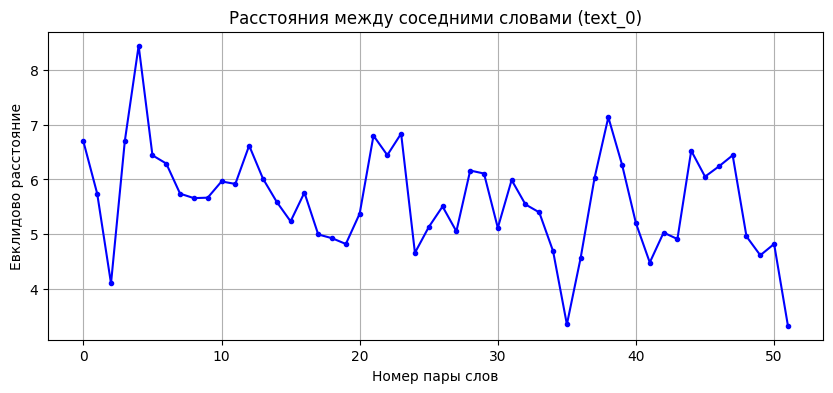

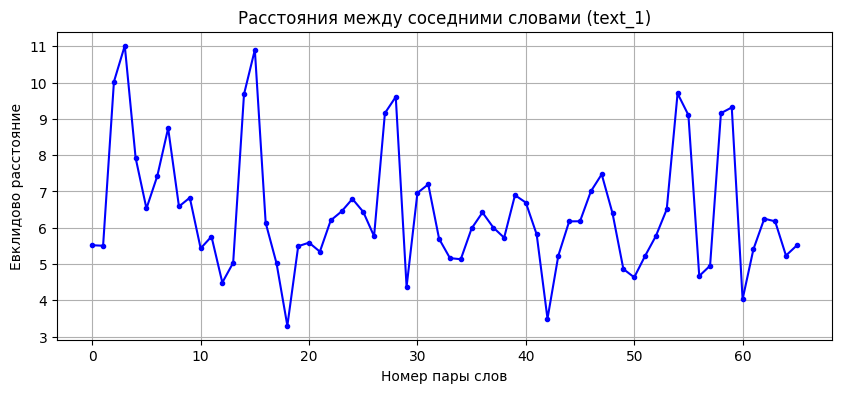

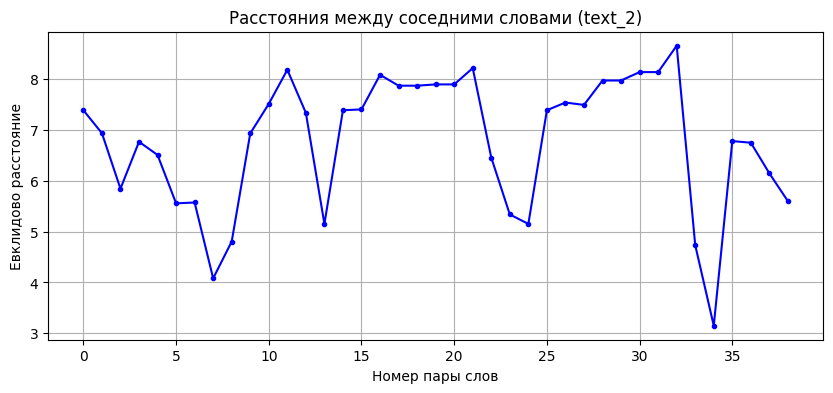

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
#Расчет евклидового расстояния между соседними векторами. Вывод графического представления расстояния (по умолчания показывает первые три)

from scipy.spatial import distance
import matplotlib.pyplot as plt
from google.colab import files
import gc

def calculate_distances(input_npz, output_npz):
    # Загрузка данных
    data = np.load(input_npz)
    distances = {}

    # Обработка каждого текста
    for key in tqdm(data.files, desc="Обработка текстов"):
        vectors = data[key]

        # Проверка на пустые тексты
        if len(vectors) < 2:
            print(f"Текст {key} содержит менее 2 слов. Пропускаем.")
            continue

        # Вычисление расстояний через матричные операции
        diff = vectors[1:] - vectors[:-1]
        dists = np.linalg.norm(diff, axis=1)
        distances[key] = dists.astype(np.float32)  # Экономия памяти

        # Очистка памяти
        del vectors, diff
        gc.collect()

    # Сохранение результатов
    np.savez(output_npz, **distances)
    print(f"Результаты сохранены в {output_npz}")

# Загрузка файла
uploaded = files.upload()
input_filename = next(iter(uploaded))
output_filename = 'distances.npz'

calculate_distances(input_filename, output_filename)

# Визуализация
data = np.load(output_filename)
for key in data.files[:3]:  # Показать первые 3 текста
    plt.figure(figsize=(10, 4))
    plt.plot(data[key], marker='o', linestyle='-', color='b', markersize=3)
    plt.title(f'Расстояния между соседними словами ({key})')
    plt.xlabel('Номер пары слов')
    plt.ylabel('Евклидово расстояние')
    plt.grid(True)
    plt.show()

# Скачивание
files.download(output_filename)

In [ ]:
#Числовой вывод расстояния (выводит массивы ВСЕХ текстов)

data = np.load('distances.npz')
for key in data.files:
    print(f"Текст {key}:")
    print(data[key])

Текст text_0:
[ 4.15924454  5.02652168  5.4819808   6.55553246  6.15154696  4.09564114
  5.55634832  5.17249775  9.57527542  0.          9.57527542  9.57527542
  0.         10.3085041   4.30720997  5.82132912  7.44623423]
Текст text_1:
[4.73930645 5.21269321 5.31574869 6.2528286  7.02581072 5.72988224
 5.4748497  6.65475368 4.70092392 6.2528286  7.02581072 5.56294727]
Текст text_2:
[3.69180274 5.91275454 6.31093788 5.94601774 5.2796483  5.82480001
 6.78237486 4.78866577 4.37498617 4.80437088 2.93240929 4.98131371
 5.94601774 6.31093788 5.46825266 5.75299025 6.88833714 5.82864904
 6.18437576]
Текст text_3:
[5.87693644 6.08343077 6.27229309 5.80279398 6.67513943 5.55649519
 3.66330957 9.31435585 9.10509491 5.04555988 5.04555988 5.22664452]
Текст text_4:
[ 5.47173834  5.6484766   7.15243244  7.58465004  4.05352449  6.14199448
  6.21587038  9.16281891 10.61507988  6.55311394  7.12684202  6.74240732
  5.05799007  6.29711962  9.31773663  9.2134037   4.83969545  5.35318661
  5.89797306  6.031

Saving jokes_distances.npz to jokes_distances (9).npz


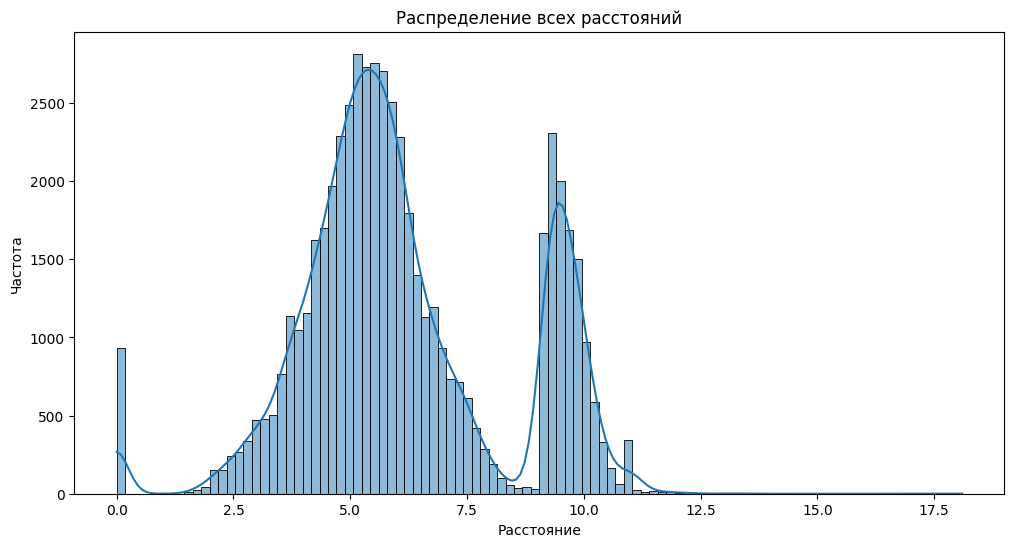


Кластеризация HDBSCAN...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 HDBSCAN - Размеры кластеров:
   Кластер 0: 42233 точек (78.3%)
   Кластер 1: 11684 точек (21.7%)
   Соотношение размеров: 3.6:1

 HDBSCAN:
   Silhouette Score: 0.68
   Calinski-Harabasz Index: 73475.56
   Davies-Bouldin Index: 0.62

Кластеризация KMeans...

 KMeans - Размеры кластеров:
   Кластер 0: 40277 точек (73.2%)
   Кластер 1: 14720 точек (26.8%)
   Соотношение размеров: 2.7:1

 KMeans:
   Silhouette Score: 0.68
   Calinski-Harabasz Index: 130609.16
   Davies-Bouldin Index: 0.39

Кластеризация DBSCAN...

 DBSCAN - Размеры кластеров:
   Кластер 0: 54056 точек (98.3%)
   Кластер 1: 932 точек (1.7%)
   Кластер 2: 6 точек (0.0%)
   Соотношение размеров: 9009.3:1

 DBSCAN:
   Silhouette Score: 0.46
   Calinski-Harabasz Index: 2804.05
   Davies-Bouldin Index: 4.88

Кластеризация Gaussian Mixture...

 GMM - Размеры кластеров:
   Кластер 0: 43217 точек (78.6%)
   Кластер 1: 11780 точек (21.4%)
   Соотношение размеров: 3.7:1

 GMM:
   Silhouette Score: 0.69
   Calinski-Harabasz Index: 1

15849

In [22]:
#Вывод гистограммы распределения всех расстояний. Оценка метрики качества кластеризации разных алгоритмов кластеризации

import hdbscan
import gc
import dask.array as da
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

def load_data(filename):
    data = np.load(filename)
    arrays = [da.from_array(data[key], chunks=10000) for key in data.files]
    return da.concatenate(arrays, axis=0)

def optimize_memory(distances):
    return distances.astype(np.float32).reshape(-1, 1)

def cluster_hdbscan(distances, min_cluster_size=1000, cluster_selection_epsilon=0.5):
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        cluster_selection_method='eom',
        cluster_selection_epsilon=cluster_selection_epsilon,
        min_samples=100
    )
    labels = clusterer.fit_predict(distances.compute().reshape(-1, 1))
    return labels, clusterer

def cluster_kmeans(distances, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(distances.compute().reshape(-1, 1))
    return labels, kmeans

def cluster_dbscan(distances, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(distances.compute().reshape(-1, 1))
    return labels, dbscan

def cluster_gmm(distances, n_components=2):
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    labels = gmm.fit_predict(distances.compute().reshape(-1, 1))
    return labels, gmm

def evaluate_clustering(X, labels, algorithm_name):
    if len(np.unique(labels)) < 2:
        print(f"{algorithm_name}: Недостаточно кластеров для оценки.")
        return

    silhouette = silhouette_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    davies = davies_bouldin_score(X, labels)

    print(f"\n {algorithm_name}:")
    print(f"   Silhouette Score: {silhouette:.2f}")
    print(f"   Calinski-Harabasz Index: {calinski:.2f}")
    print(f"   Davies-Bouldin Index: {davies:.2f}")

def analyze_clusters(labels, algorithm_name):
    unique_labels, counts = np.unique(labels[labels != -1], return_counts=True)
    total = counts.sum() if len(counts) > 0 else 0

    print(f"\n {algorithm_name} - Размеры кластеров:")
    if len(counts) == 0:
        print("   Все точки отнесены к шуму.")
    else:
        for label, count in zip(unique_labels, counts):
            print(f"   Кластер {label}: {count} точек ({count / total * 100:.1f}%)")
        if len(counts) > 1:
            ratio = max(counts) / min(counts)
            print(f"   Соотношение размеров: {ratio:.1f}:1")

def plot_distribution(distances, title):
    plt.figure(figsize=(12, 6))
    sns.histplot(distances.compute().flatten(), bins=100, kde=True)
    plt.title(title)
    plt.xlabel('Расстояние')
    plt.ylabel('Частота')
    plt.show()

# Загрузка данных
uploaded = files.upload()
filename = next(iter(uploaded))
all_distances = load_data(filename)

# Оптимизация памяти
distances_optimized = optimize_memory(all_distances)

# Визуализация распределения
plot_distribution(distances_optimized, 'Распределение всех расстояний')

# Кластеризация HDBSCAN
print("\nКластеризация HDBSCAN...")
labels_hdbscan, _ = cluster_hdbscan(distances_optimized, min_cluster_size=1000, cluster_selection_epsilon=0.5)
analyze_clusters(labels_hdbscan, "HDBSCAN")
evaluate_clustering(distances_optimized.compute().reshape(-1, 1), labels_hdbscan, "HDBSCAN")

# Кластеризация KMeans
print("\nКластеризация KMeans...")
labels_kmeans, _ = cluster_kmeans(distances_optimized, n_clusters=2)
analyze_clusters(labels_kmeans, "KMeans")
evaluate_clustering(distances_optimized.compute().reshape(-1, 1), labels_kmeans, "KMeans")

# Кластеризация DBSCAN
print("\nКластеризация DBSCAN...")
labels_dbscan, _ = cluster_dbscan(distances_optimized, eps=0.5, min_samples=5)
analyze_clusters(labels_dbscan, "DBSCAN")
evaluate_clustering(distances_optimized.compute().reshape(-1, 1), labels_dbscan, "DBSCAN")

# Кластеризация GMM
print("\nКластеризация Gaussian Mixture...")
labels_gmm, _ = cluster_gmm(distances_optimized, n_components=2)
analyze_clusters(labels_gmm, "GMM")
evaluate_clustering(distances_optimized.compute().reshape(-1, 1), labels_gmm, "GMM")


# Очистка памяти
del distances_optimized, labels_hdbscan, labels_kmeans, labels_dbscan, labels_gmm,
gc.collect()

Saving jokes_distances.npz to jokes_distances (16).npz
Saving texts_distances.npz to texts_distances (21).npz


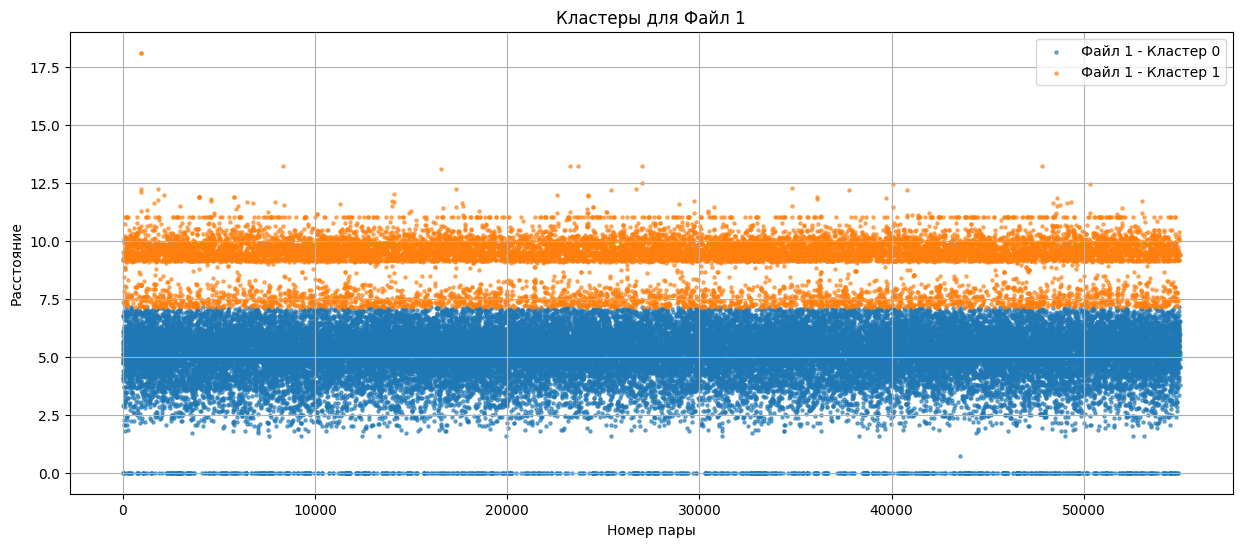

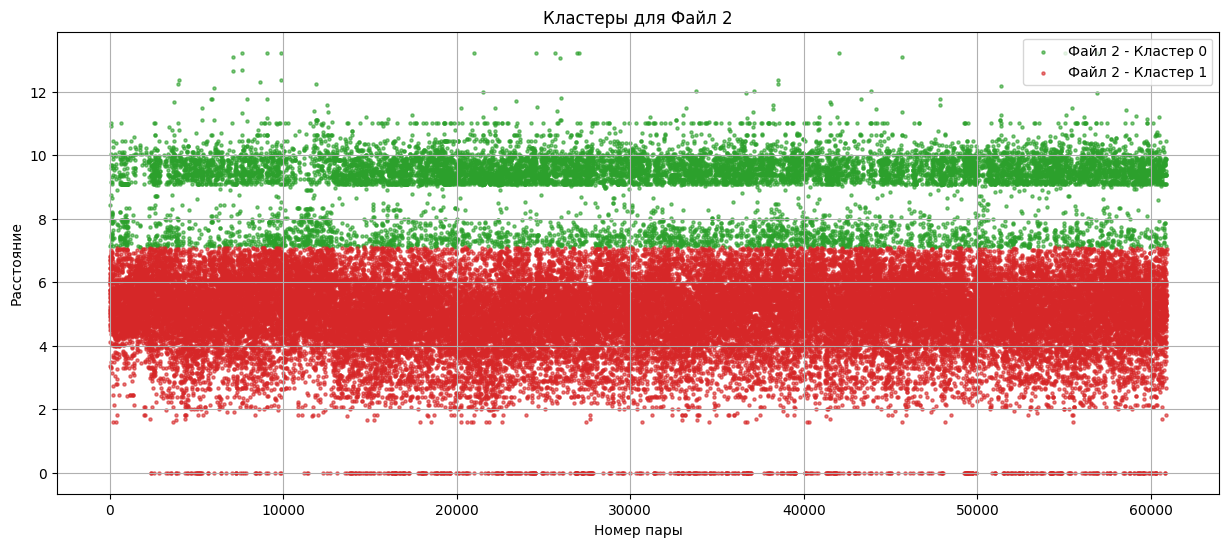

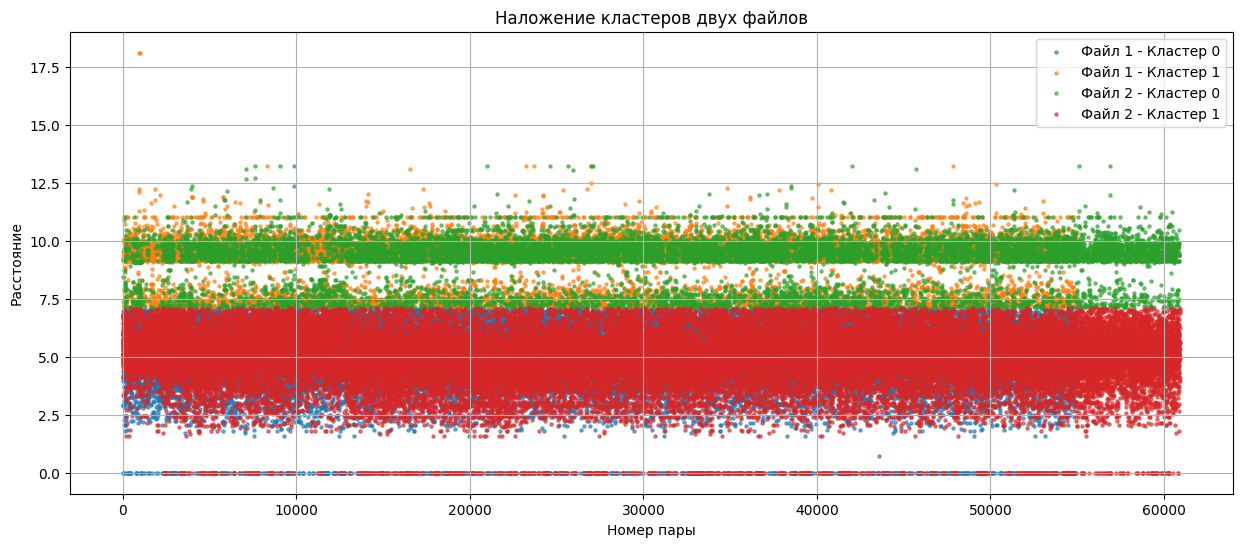

12693

In [30]:
#Кластеризация алгоритмом KMeans. Визуализация кластеров на точечном графике

import dask.array as da
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import gc

def load_data(filename):
    data = np.load(filename)
    arrays = [da.from_array(data[key], chunks=10000) for key in data.files]
    return da.concatenate(arrays, axis=0)

def optimize_memory(distances):
    return distances.astype(np.float32).reshape(-1, 1)

def cluster_kmeans(distances, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    labels = kmeans.fit_predict(distances.compute().reshape(-1, 1))
    return labels, kmeans

def plot_clusters(distances, labels, title, colors, alpha=0.6):
    plt.figure(figsize=(15, 6))
    for i in range(len(colors)):
        plt.scatter(
            np.where(labels == i)[0],
            distances.compute()[labels == i],
            color=colors[i],
            s=5,
            alpha=alpha,
            label=f'{title} - Кластер {i}'
        )
    plt.title(f'Кластеры для {title}')
    plt.xlabel('Номер пары')
    plt.ylabel('Расстояние')
    plt.legend()
    plt.grid(True)
    plt.show()

# Загрузка двух файлов
uploaded = files.upload()
file_names = list(uploaded.keys())
if len(file_names) != 2:
    raise ValueError("Пожалуйста, загрузите ровно два файла.")

# Обработка первого файла
file1 = file_names[0]
all_distances1 = load_data(file1)
distances_optimized1 = optimize_memory(all_distances1)
labels_kmeans1, kmeans1 = cluster_kmeans(distances_optimized1, n_clusters=2)

# Обработка второго файла
file2 = file_names[1]
all_distances2 = load_data(file2)
distances_optimized2 = optimize_memory(all_distances2)
labels_kmeans2, kmeans2 = cluster_kmeans(distances_optimized2, n_clusters=2)

# Визуализация кластеров для каждого файла
colors1 = ['#1f77b4', '#ff7f0e']  # Синий и оранжевый для первого файла
colors2 = ['#2ca02c', '#d62728']  # Зеленый и красный для второго файла

plot_clusters(distances_optimized1, labels_kmeans1, title='Файл 1', colors=colors1)
plot_clusters(distances_optimized2, labels_kmeans2, title='Файл 2', colors=colors2)

# Наложение кластеров на одном графике
plt.figure(figsize=(15, 6))
for i in range(len(colors1)):
    plt.scatter(
        np.where(labels_kmeans1 == i)[0],
        distances_optimized1.compute()[labels_kmeans1 == i],
        color=colors1[i],
        s=5,
        alpha=0.6,
        label=f'Файл 1 - Кластер {i}'
    )
for i in range(len(colors2)):
    plt.scatter(
        np.where(labels_kmeans2 == i)[0],
        distances_optimized2.compute()[labels_kmeans2 == i],
        color=colors2[i],
        s=5,
        alpha=0.6,
        label=f'Файл 2 - Кластер {i}'
    )

plt.title('Наложение кластеров двух файлов')
plt.xlabel('Номер пары')
plt.ylabel('Расстояние')
plt.legend()
plt.grid(True)
plt.show()

# Очистка памяти
del distances_optimized1, labels_kmeans1, distances_optimized2, labels_kmeans2
gc.collect()